In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Bio
from Bio import SeqIO

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import StratifiedKFold

# Preprocessing fasta dataset

In [2]:
def parse_fasta(fasta_file):
    sequences = []
    labels = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(str(record.seq))
        labels.append(1 if 'posi' in fasta_file else 0)  # Positive = 1, Negative = 0
    return sequences, labels

def load_data(positive_train, negative_train, positive_test, negative_test):
    # Loading training data
    pos_train_sequences, pos_train_labels = parse_fasta(positive_train)
    neg_train_sequences, neg_train_labels = parse_fasta(negative_train)

    # Loading testing data
    pos_test_sequences, pos_test_labels = parse_fasta(positive_test)
    neg_test_sequences, neg_test_labels = parse_fasta(negative_test)

    # Combining positive and negative samples for both train and test
    train_sequences = pos_train_sequences + neg_train_sequences
    train_labels = pos_train_labels + neg_train_labels

    test_sequences = pos_test_sequences + neg_test_sequences
    test_labels = pos_test_labels + neg_test_labels

    return train_sequences, train_labels, test_sequences, test_labels

# Extracting AAC Features

In [3]:
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

def amino_acid_composition(sequence):
    """Calculates the Amino Acid Composition (AAC) for a given sequence."""
    composition = np.zeros(len(AMINO_ACIDS))
    for aa in sequence:
        if aa in AMINO_ACIDS:
            composition[AMINO_ACIDS.index(aa)] += 1
    return composition / len(sequence)  # Normalize by sequence length

def extract_aac_features(sequences):
    """Extract AAC features for a list of sequences."""
    features = [amino_acid_composition(seq) for seq in sequences]
    return np.array(features)

In [4]:
# Paths to FASTA files
POSITIVE_TRAIN_FASTA = './data/UniSwiss-Tr-posi.fasta'
NEGATIVE_TRAIN_FASTA = './data/UniSwiss-Tr-nega.fasta'
POSITIVE_TEST_FASTA = './data/UniSwiss-Tst-posi.fasta'
NEGATIVE_TEST_FASTA = './data/UniSwiss-Tst-nega.fasta'

# Loading sequences and labels
train_sequences, train_labels, test_sequences, test_labels = load_data(
    POSITIVE_TRAIN_FASTA, NEGATIVE_TRAIN_FASTA, POSITIVE_TEST_FASTA, NEGATIVE_TEST_FASTA
)

# Extracting AAC features
X_train = extract_aac_features(train_sequences)
X_test = extract_aac_features(test_sequences)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [27]:
# import os
# print(os.getcwd())

In [6]:
# Spliting training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
X_val.shape

(1800, 20)

In [8]:
y_val.shape

(1800,)

In [12]:
#Fully Connected Neural Network (also known as a Dense Neural Network) implemented with Keras
import absl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


def create_dense_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_dense_model((X_train_split.shape[1],))

history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
225/225 [==============================] - 2s 4ms/step - loss: 0.6712 - accuracy: 0.6022 - val_loss: 0.6325 - val_accuracy: 0.6650
Epoch 2/20
225/225 [==============================] - 1s 3ms/step - loss: 0.6082 - accuracy: 0.6792 - val_loss: 0.5842 - val_accuracy: 0.6872
Epoch 3/20
225/225 [==============================] - 1s 3ms/step - loss: 0.5832 - accuracy: 0.6881 - val_loss: 0.5814 - val_accuracy: 0.6783
Epoch 4/20
225/225 [==============================] - 1s 3ms/step - loss: 0.5722 - accuracy: 0.6958 - val_loss: 0.5653 - val_accuracy: 0.6928
Epoch 5/20
225/225 [==============================] - 1s 3ms/step - loss: 0.5644 - accuracy: 0.6971 - val_loss: 0.5629 - val_accuracy: 0.6917
Epoch 6/20
225/225 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.7014 - val_loss: 0.5555 - val_accuracy: 0.7033
Epoch 7/20
225/225 [==============================] - 1s 3ms/step - loss: 0.5518 - accuracy: 0.7036 - val_loss: 0.5500 - val_accuracy: 0.7033
Epoch 

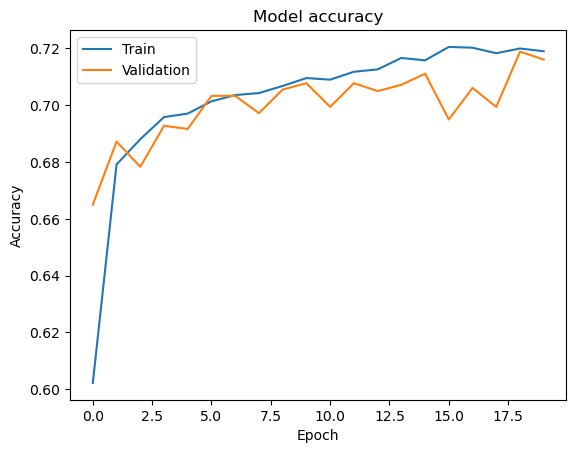

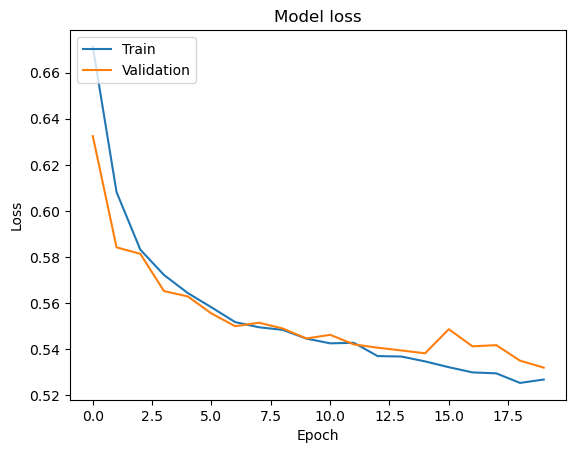

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [14]:
# Predicting on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculating performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.6824
Precision: 0.6476
Recall: 0.8005
F1 Score: 0.7160
AUC: 0.6824


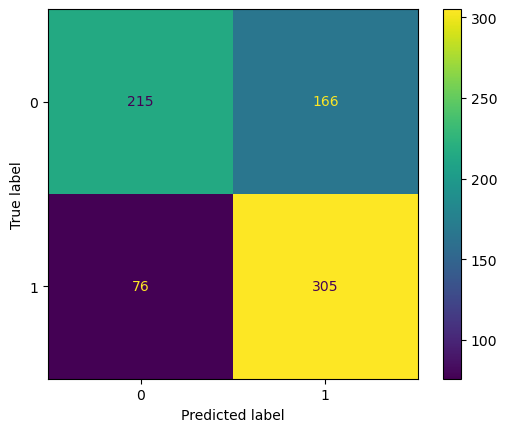

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

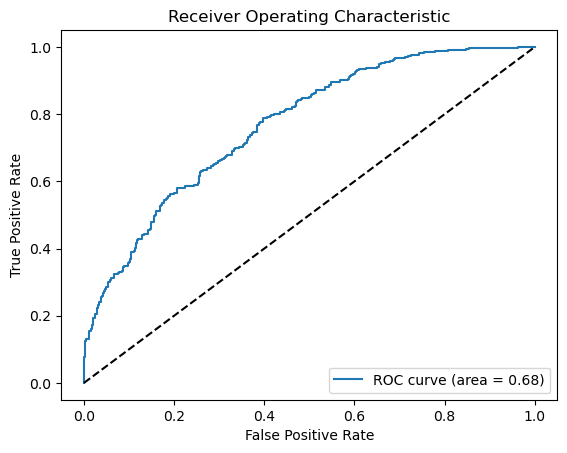

In [17]:
# Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [19]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Calculating performance metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)

    return accuracy, precision, recall, f1, auc

In [20]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc = evaluate_model(rf_model, X_train_split, y_train_split, X_val, y_val)

print("Random Forest:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"AUC: {rf_auc:.4f}")

Random Forest:
Accuracy: 0.7256
Precision: 0.7171
Recall: 0.7285
F1 Score: 0.7228
AUC: 0.7256


In [23]:
# Predicting with Random forest
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC: {auc_rf:.4f}")

Random Forest Results:
Accuracy: 0.6982
Precision: 0.7013
Recall: 0.6903
F1 Score: 0.6958
AUC: 0.6982


In [21]:
# Support Vector Machine
svm_model = SVC(probability=True, random_state=42)
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_auc = evaluate_model(svm_model, X_train_split, y_train_split, X_val, y_val)

print("SVM:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")
print(f"AUC: {svm_auc:.4f}")

SVM:
Accuracy: 0.7339
Precision: 0.7064
Recall: 0.7839
F1 Score: 0.7432
AUC: 0.7348


In [24]:
# Predicting with SVM
y_pred_svm = svm_model.predict(X_test)


accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_pred_svm)


print("\nSVM Results:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"AUC: {auc_svm:.4f}")


SVM Results:
Accuracy: 0.7073
Precision: 0.6854
Recall: 0.7664
F1 Score: 0.7237
AUC: 0.7073


In [25]:
print("Comparison of Models:")
print(f"Dense NN Accuracy: {accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"SVM Accuracy: {accuracy_rf:.4f}")

Comparison of Models:
Dense NN Accuracy: 0.6824
Random Forest Accuracy: 0.7256
SVM Accuracy: 0.6982


# Model Performance Summary:
## Dense Neural Network (Dense NN):
Accuracy: 0.6824
This model shows relatively lower performance compared to the others. It may benefit from further tuning, increased complexity, or more training data.

## Random Forest:
Accuracy: 0.7256
The Random Forest model performed the best among the three. This could indicate that the ensemble approach of Random Forest is effectively capturing the patterns in the data, making it suitable for this classification task.

## Support Vector Machine (SVM):
Accuracy: 0.6982
The SVM model performs moderately well but is still behind the Random Forest model. SVMs can perform well in high-dimensional spaces but may require careful tuning of hyperparameters like the kernel type and regularization.